# Probabilistic Mission Design - Quick Start

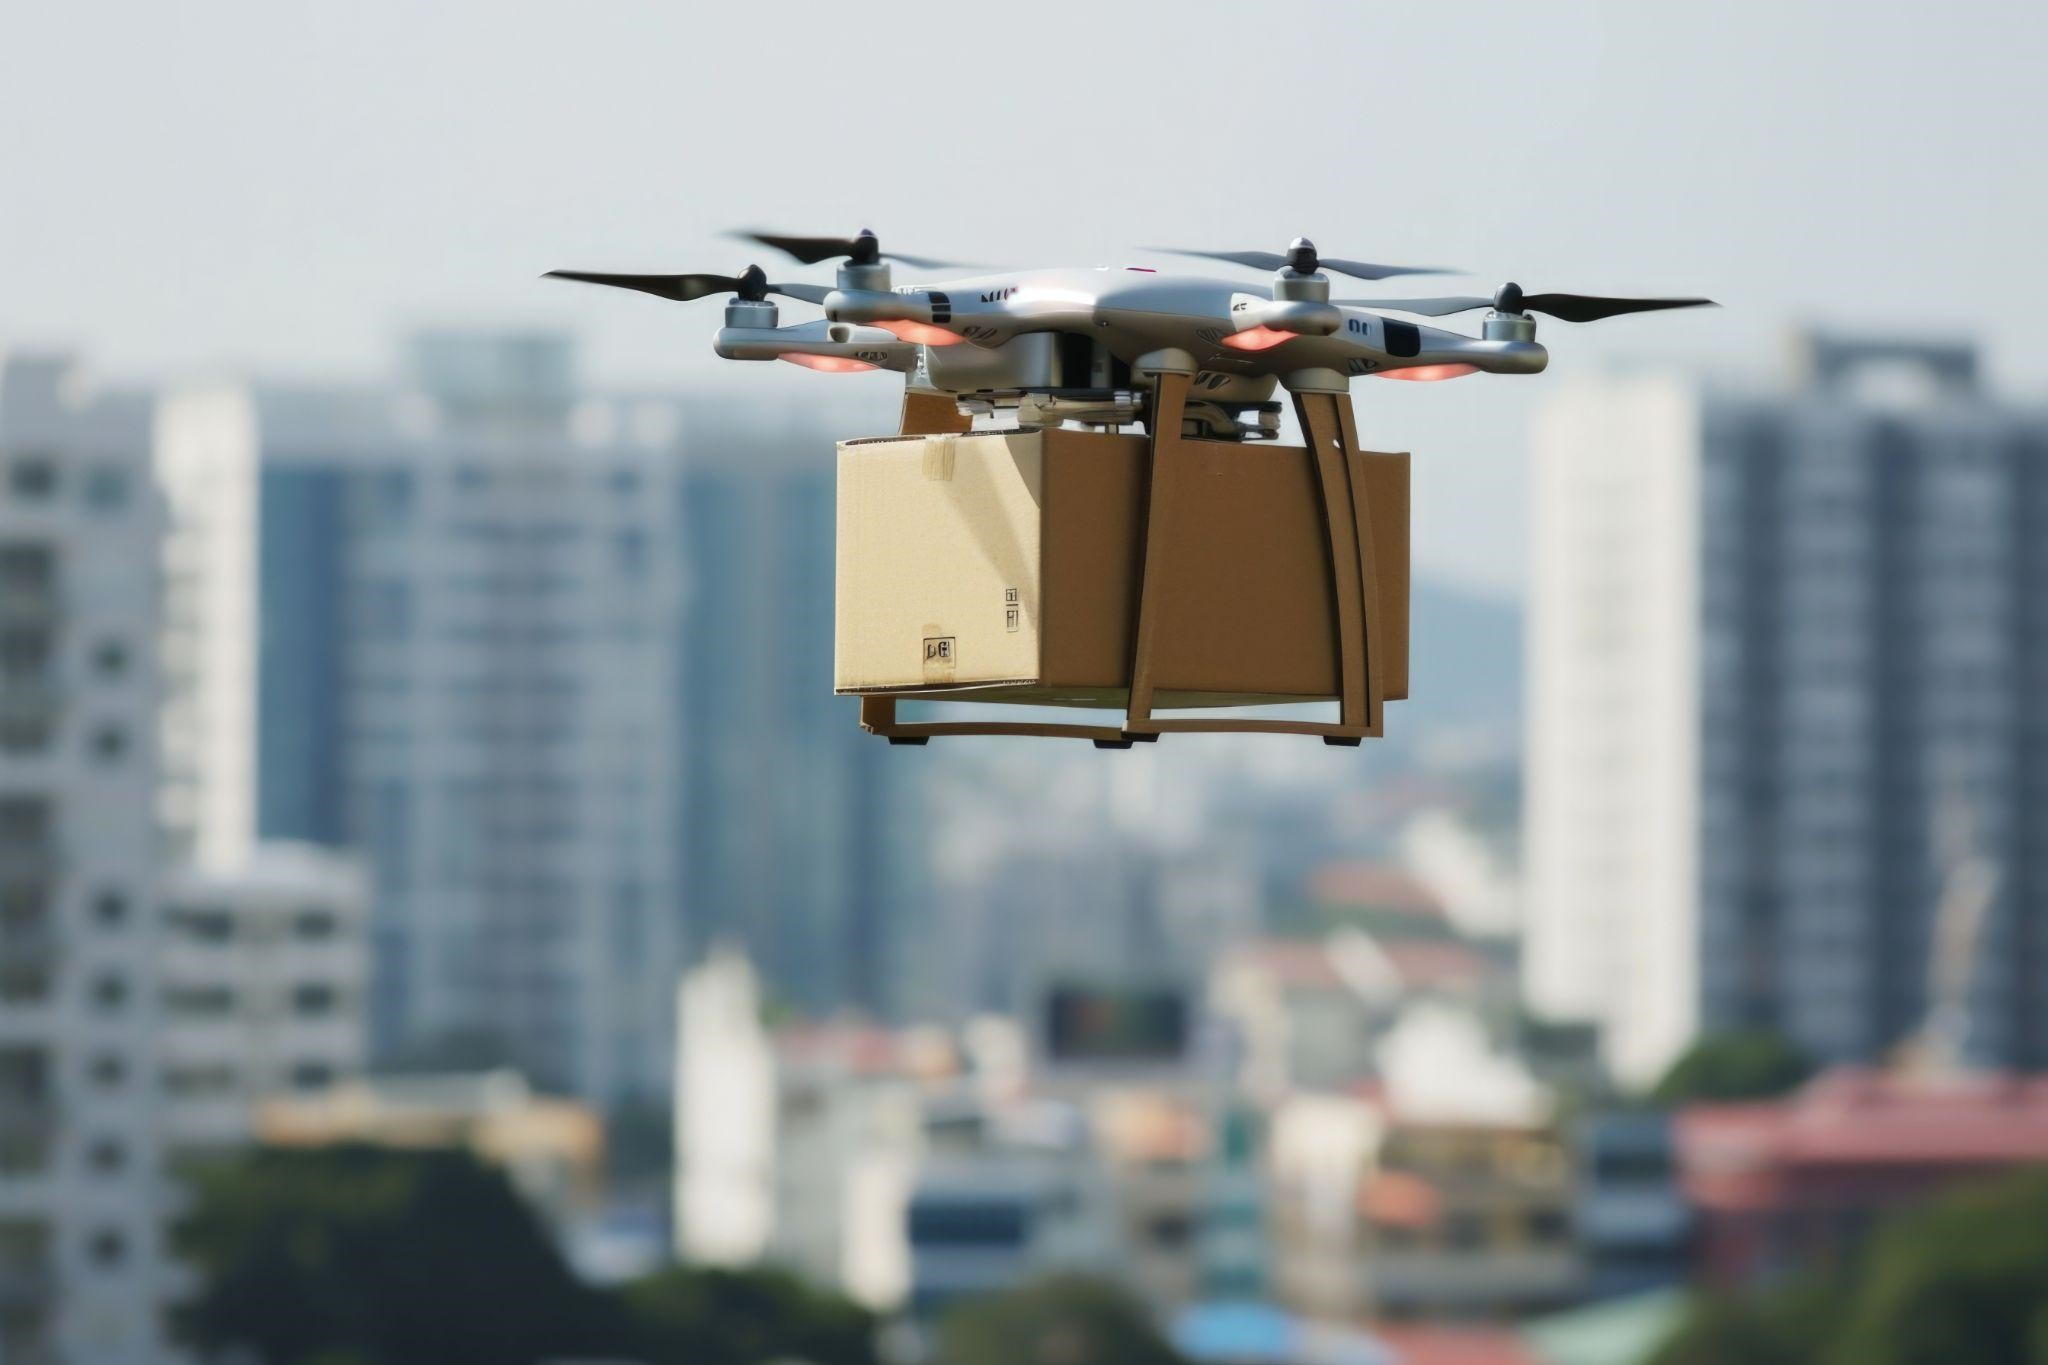

In [2]:
from numpy import eye

# The imports we will need to run Probabilistic Mission Design
from promis_project import (StaRMap, ProMis, 
                            PolarLocation, CartesianMap, CartesianLocation, CartesianRasterBand, CartesianCollection,
                            OsmLoader
                           )
import matplotlib.pyplot as plt


promis_dir /Users/zhenzhili/MASTERTHESIS/#Expert_System_Design/examples/promis/promis_project


In [4]:
# The features we will load from OpenStreetMap
# The dictionary key will be stored as the respective features location_type
# The dictionary value will be used to query the relevant geometry via Overpass
feature_description = {
    "park": "['leisure' = 'park']",
    "primary": "['highway' = 'primary']",
    "primary_link": "['highway' = 'primary_link']",
    "secondary": "['highway' = 'secondary']",
    "secondary_link": "['highway' = 'secondary_link']",
    "tertiary": "['highway' = 'tertiary']",
    "service": "['highway' = 'service']",
    "crossing": "['footway' = 'crossing']",
    "bay": "['natural' = 'bay']",
    "rail": "['railway' = 'rail']",
}

# Covariance matrices for some of the features
# Used to draw random translations representing uncertainty for the respective features
covariance = {
    "primary": 15.0 * eye(2),
    "primary_link": 15.0 * eye(2),
    "secondary": 10.0 * eye(2),
    "secondary_link": 10.0 * eye(2),
    "tertiary": 5 * eye(2),
    "service": 2.5 * eye(2),
    "operator": 20 * eye(2),
}

city_attr = "berlin"

# The mission area, points that will be estimated from 25 samples and points that will be interpolated
# origin = PolarLocation(latitude=49.878091, longitude=8.654052) # Darmstadt
# origin = PolarLocation(latitude=50.110924, longitude=8.682127) # Frankfurt
origin = PolarLocation(latitude=52.5186, longitude=13.4081) # Berlin
# origin = PolarLocation(latitude=36.8167, longitude=118.3000) # LinZi

width, height = 1000.0, 1000.0
number_of_random_maps = 20

# support = CartesianRasterBand(origin, (50, 50), width, height)  # This is the set of points that will be directly computed through sampling (expensive)
# target = CartesianRasterBand(origin, (250, 250), width, height)  # This is the set of points that will be interpolated from the support set (cheap)
support = CartesianRasterBand(origin, (26, 26), width, height)  # This is the set of points that will be directly computed through sampling (expensive)
target = CartesianRasterBand(origin, (161, 161), width, height)  # This is the set of points that will be interpolated from the support set (cheap)
# alternative = CartesianCollection(origin, [CartesianLocation(42, 42)])  # Alternatively, arbitrary points can be set for either set

In [4]:
support.data[:5]

,east,north,v0
0,-500.0,-500.0,0.0
1,-460.0,-500.0,0.0
2,-420.0,-500.0,0.0
3,-380.0,-500.0,0.0
4,-340.0,-500.0,0.0


In [5]:
target.data[:5]

,east,north,v0
0,-500.00,-500.0,0.0
1,-493.75,-500.0,0.0
2,-487.50,-500.0,0.0
3,-481.25,-500.0,0.0
4,-475.00,-500.0,0.0


In [5]:
# Setting up the Uncertainty Annotated Map from OpenStreetMap data 
load = True
if not load:
    uam = OsmLoader(origin, (width, height), feature_description).to_cartesian_map()
    uam.features.append(CartesianLocation(0.0, 0.0, location_type="operator"))  # We can manually add additional features
    uam.features.append(CartesianLocation(-200.0, 50.0, location_type="bomb"))  # We can manually add additional features
    uam.apply_covariance(covariance)  # Assigns the covariance matrices defined earlier
    uam.save(f"uam_{city_attr}.pkl")  # We can save and load these objects to avoid recomputation

In [ ]:
# This is formed logic:
generated_logic = """
% UAV properties
initial_charge ~ normal(90, 5).
charge_cost ~ normal(-0.1, 0.2).
weight ~ normal(0.2, 0.1).

% Real-time weather conditions for Darmstadt
weather(clear, 3.13, 17).

% Battery efficiency based on temperature
battery_efficiency(Efficiency) :-
    weather(_, _, Temp),
    (Temp < 0, Efficiency = 0.8; % Very cold
     Temp >= 0, Temp < 10, Efficiency = 0.85; % Cold
     Temp >= 10, Temp =< 35, Efficiency = 1.0; % Normal
     Temp > 35, Efficiency = 0.95 % Hot
    ).

% Visual line of sight
vlos(X) :-
    weather(Condition, _, _),
    (
        Condition = light_rain, distance(X, operator) < 20;
        Condition = cloudy, distance(X, operator) < 50;
        Condition = clear, distance(X, operator) < 100;
        Condition = clear, over(X, bay), distance(X, operator) < 400
    ).
    
weather_safe_for_flight :-
    weather(Condition, WindSpeed, _),
    safe_weather_condition(Condition),
    WindSpeed =< 15.  % Maximum safe wind speed

safe_weather_condition(clear).
safe_weather_condition(cloudy).
safe_weather_condition(light_rain).    

% Sufficient charge to return to operator
can_return(X) :-
    weather(_, WindSpeed, _),
    W is 1 + WindSpeed / 25,
    battery_efficiency(E),
    B is initial_charge, O is charge_cost,
    D is distance(X, operator), 0 < B + (2 * O * D * W / E). 

% Stay 100 meters away from bomb
sensitive_section(X) :-
    distance(X, bomb) < 0.

% Permits related to local features
permits(X) :-
    distance(X, service) < 15; distance(X, primary) < 15;
    distance(X, secondary) < 10; distance(X, tertiary) < 5;
    distance(X, crossing) < 5; distance(X, rail) < 5;
    over(X, park).

% Definition of a valid mission

landscape(X) :-
    weather_safe_for_flight,
    \+ sensitive_section(X),
    (
        vlos(X), weight < 25, can_return(X);
        permits(X), can_return(X)
    ).
"""
from langda import langda_solve


<pre> Langda will call the search tool to get current weather of darmstadt
 Running search tool...
[{'title': 'Darmstadt - Weather Forecast Maps - Ventusky', 'url': 'https://www.ventusky.com/darmstadt', 'content': 'Ventusky: Weather Forecast Maps\n\nDarmstadt\n\n22 °C\n\nWind28 km/h\nHumidity | 41 %\nCalculated from nearby stations (17:50 2025/05/27)\n\nWeather for the next 24 hours', 'score': 0.8674071}, {'title': 'Weather Darmstadt in May 2025: Temperature & Climate', 'url': ...

In [7]:
city_attr = "berlin"
# Setting up the probabilistic spatial relations from the map data
star_map = StaRMap(target, CartesianMap.load(f"uam_{city_attr}.pkl"))
star_map.initialize(support, number_of_random_maps, generated_logic)  # This estimates all spatial relations that are relevant to the given logic
# star_map.add_support_points(support, number_of_random_maps, ["distance"], ["primary"])  # Alternatively, we can estimate for specific relations
star_map.save(f"star_map_{city_attr}.pkl")

# Solve the mission area with ProMis
promis = ProMis(StaRMap.load(f"star_map_{city_attr}.pkl"))
landscape = promis.solve(support, generated_logic, n_jobs=4, batch_size=1)
landscape.save(f"landscape.pkl")

In [ ]:
print(type(landscape.data))
landscape.data[:5]

<class 'pandas.core.frame.DataFrame'>


,east,north,v0
0,-500.00,-500.0,0.000000
1,-493.75,-500.0,0.059375
2,-487.50,-500.0,0.118750
3,-481.25,-500.0,0.178125
4,-475.00,-500.0,0.237500


## Test: Trajectories

In [16]:
landscape = CartesianCollection.load(f"landscape.pkl")
import numpy as np
def get_confidence_at_point(east: float, north: float) -> float:

    # 找到最接近的网格点
    distances = np.sqrt((landscape.data.east - east)**2 + 
                        (landscape.data.north - north)**2)
    closest_idx = distances.idxmin()
    return landscape.data.loc[closest_idx, 'v0']

def set_path(x_pt, y_pt, path_lists):
    print(get_confidence_at_point(x_pt,y_pt))
    image = landscape.scatter(s=0.4, plot_basemap=True, rasterized=True, cmap="coolwarm_r", alpha=1)
    cbar = plt.colorbar(image, ticks=[0.0, 0.5, 1.0], aspect=30, pad=0.02)
    cbar.ax.set_yticklabels(['0.0', '0.5', '1.0'])
    cbar.solids.set(alpha=1)

    ticks = [-500, 0, 500]
    labels = ["0", "0.5", "1"]
    
    plt.xlabel("Easting / km")
    plt.ylabel("Northing / km")
    plt.xticks(ticks, labels)
    plt.yticks(ticks, labels)
    plt.xlim([-500, 500])
    plt.ylim([-500, 500])
    plt.title("P(mission_landscape)")

    for i, path in enumerate(path_lists):
        confidence_list = []
        valid = True
        for (x,y) in path:
            confidence = np.around(get_confidence_at_point(x,y),3)
            if confidence < 0.4:
                confidence_list.append(f"Invalid")
                valid = False
            else:
                confidence_list.append(confidence)
        if valid:
            marker = "."
        else:
            marker = "x"
        plt.plot(*zip(*path), 
                marker=marker,          # 使用小点标记（也可以用 'o' 配合 markersize）
                markersize=5,        # 点的大小（原来默认约6-8）
                linewidth=1.5,       # 线条粗细
                alpha=0.8,           # 透明度
                # label=f'Path{i}'
                )
        
        print(f"Path{i}: {valid}",confidence_list)
    
    plt.legend()
    plt.title("Path Validity Visualization")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.axis('equal')

    # —— 在这里插入一个特殊标记 —— #
    # x_pt, y_pt = -50, 270  # 单位 m；如果想用 km，就写 0.1, 0.2
    plt.scatter(
        x_pt, y_pt,
        marker='*',       # 星形
        s=100,            # 大小
        c='red',          # 颜色
        edgecolors='black',
        linewidths=1.2,
        zorder=5          # 确保点画在最上层
    )

    plt.show()

1.0
Lowered zoom level to keep map size reasonable. (z = 15)
Path0: True [0.593, 0.565, 0.514, 0.517, 0.564, 0.634, 0.625, 0.62, 0.72, 0.788, 0.858, 0.889, 0.936, 0.968, 0.994, 0.999, 1.0, 1.0]
Path1: True [0.518, 0.499, 0.465, 0.499, 0.498, 0.523, 0.558, 0.547, 0.577, 0.604, 0.633, 0.507, 0.832, 0.918, 0.87, 0.99, 0.996, 1.0, 1.0, 1.0]
Path2: True [0.52, 0.574, 0.6, 0.574, 0.713, 0.713, 0.716, 0.765, 0.824, 0.905, 0.984, 0.991, 1.0, 1.0]
Path3: True [0.52, 0.542, 0.585, 0.611, 0.583, 0.506, 0.544, 0.573, 0.591, 0.623, 0.623, 0.68, 0.658, 0.774, 0.855, 0.881, 0.943, 0.949, 0.974, 1.0, 1.0, 1.0]
Path4: True [0.519, 0.435, 0.497, 0.493, 0.653, 0.638, 0.633, 0.659, 0.765, 0.836, 0.889, 0.936, 0.986, 0.994, 1.0, 1.0, 1.0, 1.0]
Path5: True [0.52, 0.574, 0.6, 0.566, 0.516, 0.623, 0.648, 0.641, 0.665, 0.718, 0.776, 0.756, 0.743, 0.804, 0.772, 0.736, 0.761, 0.861, 0.791, 0.803, 0.874, 0.954, 0.991, 0.992, 1.0, 1.0, 1.0, 1.0]
Path6: True [0.66, 0.672, 0.586, 0.545, 0.583, 0.575, 0.544, 0.484, 0

/var/folders/05/6btr2vg13b9gvgs3gxt8fw_40000gn/T/ipykernel_31860/141327130.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


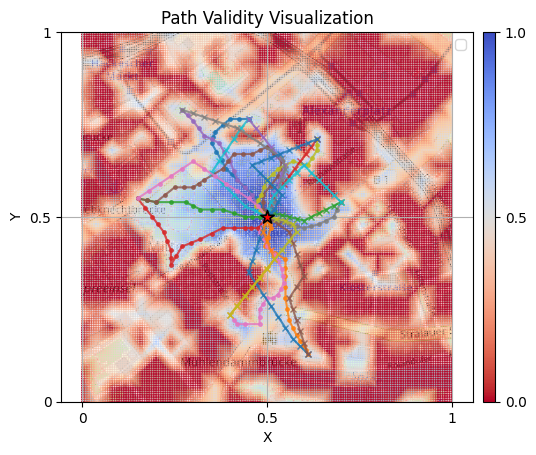

In [ ]:
# === VALID PATHS (从原始起点生成) ===
paths = [
    # Path 1: 原始8点 -> 细化18点
    [(-50,265), (-75,265), (-100,265), (-120,248), (-140,230), (-145,215), (-150,200), 
     (-137,177), (-123,153), (-110,130), (-95,115), (-80,100), (-63,83), (-47,67), 
     (-30,50), (-20,33), (-10,17), (0,0)],
    # Path 2: 原始10点 -> 细化22点  
    [(110,-370), (105,-360), (100,-350), (90,-335), (80,-320), (70,-300), (60,-280),
     (55,-250), (50,-220), (50,-190), (50,-160), (50,-138), (50,-115), (23,-98),
     (-5,-80), (3,-55), (10,-30), (7,-20), (4,-10), (0,0)],
    # Path 3: 原始7点 -> 细化14点
    [(-350,50), (-325,45), (-300,40), (-260,40), (-220,40), (-200,30), (-180,20),
     (-150,20), (-120,20), (-90,10), (-60,0), (-40,0), (-20,0), (0,0)],
    # Path 4: 原始11点 -> 细化25点
    [(-350,50), (-330,25), (-310,0), (-295,-20), (-280,-40), (-270,-65), (-260,-90),
     (-260,-110), (-260,-130), (-245,-105), (-230,-80), (-205,-70), (-180,-60),
     (-150,-45), (-120,-30), (-90,-30), (-60,-30), (-43,-30), (-25,-30), (-13,-20),
     (-7,-10), (0,0)],
    # Path 5: 原始9点 -> 细化18点
    [(-230,290), (-215,275), (-200,260), (-185,240), (-170,220), (-150,210), (-130,200),
     (-115,175), (-100,150), (-90,125), (-80,100), (-60,80), (-40,60), (-30,40),
     (-20,20), (-13,13), (-7,7), (0,0)],
    # Path 6: 原始14点 -> 细化32点
    [(-350,50), (-325,45), (-300,40), (-275,60), (-250,80), (-225,80), (-200,80),
     (-185,90), (-170,100), (-145,115), (-120,130), (-105,150), (-90,170), (-65,170),
     (-40,170), (-20,180), (0,190), (20,170), (40,150), (35,130), (30,110),
     (10,85), (-10,60), (-10,40), (-10,20), (-7,13), (-3,7), (0,0)],
    # Path 7: 原始12点 -> 细化25点
    [ (-90,-278), (-80,-290), (-60,-290), (-20,-290), (-20,-270), (-20,-250),
     (-10,-235), (0,-220), (15,-220), (30,-210), (38,-195), (45,-180), (43,-160),
     (40,-140), (30,-120), (20,-100), (10,-90), (0,-80), (-10,-60), (-20,-40),
     (-13,-27), (-7,-13), (0,0)],
    # Path 8: 原始7点 -> 细化12点
    [(200,40), (190,20), (180,0), (160,-10), (140,-20), (120,-25), (100,-30),
     (80,-25), (60,-20), (45,-15), (30,-10), (15,-5), (0,0)],
    # Path 9: 原始9点 -> 细化20点
    [(135,210), (135,195), (135,180), (123,160), (110,140), (90,145), (70,150),
     (50,140), (30,130), (15,115), (0,100), (-8,80), (-15,60), (-23,45), (-30,30),
     (-20,20), (-10,10), (0,0)],
    # Valid10: 从起点(-50, 265)生成
    [(-50, 265), (-70, 240), (-90, 210), (-110, 180), (-130, 150), (-150, 120), (-120, 90), (-90, 60), (-60, 30), (-30, 15), (0, 0)],
    # Valid11: 从起点(110, -370)生成  
    [(110, -370), (90, -350), (70, -330), (50, -300), (30, -270), (10, -240), (-10, -210), (-30, -180), (-50, -150), (-40, -120), (-30, -90), (-20, -60), (-10, -30), (0, 0)],   
    # Valid16: 从起点(-100, -265)生成
    [(-100, -265), (-80, -240), (-60, -215), (-40, -190), (-20, -165), (0, -140), (20, -115), (10, -90), (0, -65), (-10, -40), (-5, -20), (0, 0)],
    # Valid17: 从起点(200, 40)生成
    [(200, 40), (180, 30), (160, 20), (140, 10), (120, 0), (100, -10), (80, -5), (60, 0), (40, 5), (20, 10), (10, 5), (0, 0)],
    # Valid18: 从起点(135, 210)生成
    [(135, 210), (120, 190), (105, 170), (90, 150), (75, 130), (60, 110), (45, 90), (30, 70), (15, 50), (10, 30), (5, 15), (0, 0)],
    # Invalid13: 从起点(-50, 265)生成 - 直线穿越中央红色区域
    [(-50, 265), (-30, 240), (-10, 215), (10, 190), (30, 165), (50, 140), (40, 115), (30, 90), (20, 65), (10, 40), (5, 20), (0, 0)],
    # Invalid14: 从起点(110, -370)生成 - 穿越右侧红色区域后直行
    [(110, -370), (100, -340), (90, -310), (80, -280), (70, -250), (60, -220), (80, -190), (100, -160), (90, -130), (80, -100), (70, -70), (60, -40), (30, -20), (0, 0)],
    # Invalid15: 从起点(-350, 50)生成 - 向上穿越左上红色区域
    [(-350, 50), (-320, 70), (-290, 90), (-260, 110), (-230, 130), (-200, 150), (-170, 130), (-140, 110), (-110, 90), (-80, 70), (-50, 50), (-25, 30), (0, 0)],
    # Invalid17: 从起点(-230, 290)生成 - 向右上穿越红色区域
    [(-230, 290), (-200, 280), (-170, 270), (-140, 260), (-110, 250), (-80, 240), (-50, 220), (-20, 200), (10, 180), (40, 160), (50, 130), (40, 100), (30, 70), (20, 40), (10, 20), (0, 0)],
    # Invalid19: 从起点(-100, -265)生成 - 向东北穿越红色区域
    [(-100, -265), (-80, -240), (-60, -215), (-40, -190), (-20, -165), (0, -140), (20, -115), (40, -90), (60, -65), (80, -40), (70, -20), (50, -10), (25, -5), (0, 0)],
    # Invalid20: 从起点(200, 40)生成 - 向北穿越右上红色区域
    [(200, 40), (180, 60), (160, 80), (140, 100), (120, 120), (100, 140), (80, 120), (60, 100), (40, 80), (20, 60), (10, 40), (5, 20), (0, 0)],
    # Invalid21: 从起点(135, 210)生成 - 向西北穿越红色区域
    [(135, 210), (110, 200), (85, 190), (60, 180), (35, 170), (10, 160), (-15, 150), (-40, 140), (-20, 120), (0, 100), (20, 80), (40, 60), (30, 40), (20, 20), (10, 10), (0, 0)]
]
set_path(-0,-0, paths) 

0.4699999988079071
Path0: False [0.605, 'Invalid', 'Invalid', 0.662, 0.714, 0.645, 0.831, 0.94, 'Invalid', 0.58, 0.47]
Path1: False [0.425, 'Invalid', 0.46, 0.485, 0.58, 0.593, 0.505, 'Invalid', 'Invalid', 'Invalid', 0.617, 0.898, 0.477, 0.47]
Path2: False [0.64, 'Invalid', 'Invalid', 'Invalid', 'Invalid', 0.416, 0.727, 0.499, 0.457, 0.561, 'Invalid', 0.47]
Path3: False [0.49, 0.529, 0.435, 'Invalid', 0.469, 0.748, 'Invalid', 'Invalid', 'Invalid', 'Invalid', 'Invalid', 0.47]
Path4: False [0.551, 'Invalid', 'Invalid', 0.696, 0.559, 0.8, 0.641, 'Invalid', 'Invalid', 'Invalid', 'Invalid', 0.47]
Path5: False [0.605, 'Invalid', 'Invalid', 0.709, 0.726, 0.741, 0.869, 0.646, 'Invalid', 'Invalid', 'Invalid', 0.47]
Path6: False [0.425, 0.405, 0.467, 0.536, 0.446, 0.655, 'Invalid', 'Invalid', 'Invalid', 0.507, 'Invalid', 'Invalid', 'Invalid', 0.47]
Path7: True [0.425, 0.493, 0.509, 0.43, 0.602, 0.515, 0.467, 0.741, 0.846, 0.915, 0.71, 0.836, 0.47]
Path8: False [0.531, 0.427, 0.423, 'Invalid', 0.

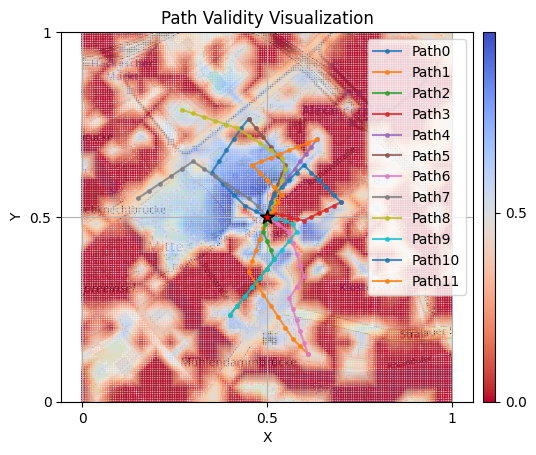

In [13]:
# === INVALID PATHS (从原始起点生成) ===
invalid_paths = [
    # Valid10: 从起点(-50, 265)生成
    [(-50, 265), (-70, 240), (-90, 210), (-110, 180), (-130, 150), (-150, 120), (-120, 90), (-90, 60), (-60, 30), (-30, 15), (0, 0)],
    # Valid11: 从起点(110, -370)生成  
    [(110, -370), (90, -350), (70, -330), (50, -300), (30, -270), (10, -240), (-10, -210), (-30, -180), (-50, -150), (-40, -120), (-30, -90), (-20, -60), (-10, -30), (0, 0)],   
    # Valid16: 从起点(-100, -265)生成
    [(-100, -265), (-80, -240), (-60, -215), (-40, -190), (-20, -165), (0, -140), (20, -115), (10, -90), (0, -65), (-10, -40), (-5, -20), (0, 0)],
    # Valid17: 从起点(200, 40)生成
    [(200, 40), (180, 30), (160, 20), (140, 10), (120, 0), (100, -10), (80, -5), (60, 0), (40, 5), (20, 10), (10, 5), (0, 0)],
    # Valid18: 从起点(135, 210)生成
    [(135, 210), (120, 190), (105, 170), (90, 150), (75, 130), (60, 110), (45, 90), (30, 70), (15, 50), (10, 30), (5, 15), (0, 0)],
    # Invalid13: 从起点(-50, 265)生成 - 直线穿越中央红色区域
    [(-50, 265), (-30, 240), (-10, 215), (10, 190), (30, 165), (50, 140), (40, 115), (30, 90), (20, 65), (10, 40), (5, 20), (0, 0)],
    # Invalid14: 从起点(110, -370)生成 - 穿越右侧红色区域后直行
    [(110, -370), (100, -340), (90, -310), (80, -280), (70, -250), (60, -220), (80, -190), (100, -160), (90, -130), (80, -100), (70, -70), (60, -40), (30, -20), (0, 0)],
    # Invalid15: 从起点(-350, 50)生成 - 向上穿越左上红色区域
    [(-350, 50), (-320, 70), (-290, 90), (-260, 110), (-230, 130), (-200, 150), (-170, 130), (-140, 110), (-110, 90), (-80, 70), (-50, 50), (-25, 30), (0, 0)],
    # Invalid17: 从起点(-230, 290)生成 - 向右上穿越红色区域
    [(-230, 290), (-200, 280), (-170, 270), (-140, 260), (-110, 250), (-80, 240), (-50, 220), (-20, 200), (10, 180), (40, 160), (50, 130), (40, 100), (30, 70), (20, 40), (10, 20), (0, 0)],
    # Invalid19: 从起点(-100, -265)生成 - 向东北穿越红色区域
    [(-100, -265), (-80, -240), (-60, -215), (-40, -190), (-20, -165), (0, -140), (20, -115), (40, -90), (60, -65), (80, -40), (70, -20), (50, -10), (25, -5), (0, 0)],
    # Invalid20: 从起点(200, 40)生成 - 向北穿越右上红色区域
    [(200, 40), (180, 60), (160, 80), (140, 100), (120, 120), (100, 140), (80, 120), (60, 100), (40, 80), (20, 60), (10, 40), (5, 20), (0, 0)],
    # Invalid21: 从起点(135, 210)生成 - 向西北穿越红色区域
    [(135, 210), (110, 200), (85, 190), (60, 180), (35, 170), (10, 160), (-15, 150), (-40, 140), (-20, 120), (0, 100), (20, 80), (40, 60), (30, 40), (20, 20), (10, 10), (0, 0)]
]

set_path(-0,-0, invalid_paths) 